In [12]:
#load libraries
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [13]:
# Reading COVID data form the BC Center for Disease Control 
new_cases = pd.read_csv('../data/COVID_by_day.csv')  

In [14]:
new_cases.tail()

,Date,New_reported_cases
60,2020-04-22,38
61,2020-04-23,24
62,2020-04-24,29
63,2020-04-25,95
64,2020-04-26,39


Text(0, 0.5, 'New COVID reported cases in BC')

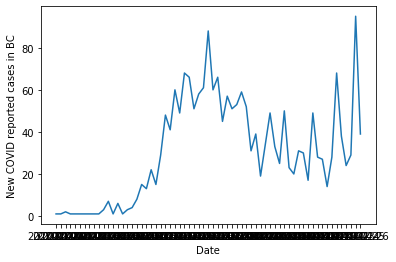

In [4]:
plt.plot(new_cases['Date'], new_cases['New_reported_cases'])
plt.xlabel('Date')
plt.ylabel('New COVID reported cases in BC')

Text(0, 0.5, 'New COVID reported cases in BC')

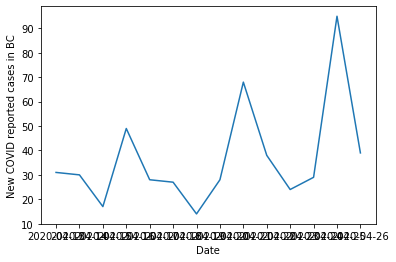

In [5]:
# We are trying to predict the following trend using Twitter content about #COVID19
plt.plot(new_cases['Date'][51:], new_cases['New_reported_cases'][51:])
plt.xlabel('Date')
plt.ylabel('New COVID reported cases in BC')

In [6]:
# Load data that was collected from the standard Twitter API
client = MongoClient("mongodb:...")
db = client.CPCS340

# Reading all tweets
tweets =  db.covid.find()
print(tweets.count())

C:\Users\Cecy\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


124335


In [7]:
# Extrating the content of fisr n tweets
n = tweets.count()
print(n)
counter = 0
tweet_date = []
tweet_content = []

for doc in tweets:
    try:
        tweet_date.append(doc['timestamp_CAD'])
        tweet_content.append(doc['text'])
    except:
        pass
    
    counter +=1   

    if counter > n:
        break

124335


C:\Users\Cecy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


In [8]:
counter

124335

In [15]:
#Number of collected tweets
data = np.vstack([tweet_date,tweet_content])
df_content = pd.DataFrame(data.T, columns=['Date', 'Content'])
df_content.shape[0]

124334

In [18]:
df_content.head()

,Date,Content
0,2020-04-13,A distillery in @CityofDuvall is not making vo...
1,2020-04-13,“I think we dream so we don’t have to be apart...
2,2020-04-13,Union representing Mission Institutional corre...
3,2020-04-13,Moving onto just approved rapid testing kits:\...
4,2020-04-13,This woman’s look is a MOOD. I don’t know who ...


### Building the second set of Features 

In [17]:
# Counts of collected tweets per day
total_tweets = df_content['Date'].value_counts()
total_tweets = total_tweets.sort_index()
total_tweets

2020-04-13    10247
2020-04-14     9792
2020-04-15    11341
2020-04-16    13266
2020-04-17    11659
2020-04-18     9427
2020-04-19     7888
2020-04-20     8444
2020-04-21     8332
2020-04-22     9216
2020-04-23     8823
2020-04-24     7066
2020-04-25     5720
2020-04-26     3113
Name: Date, dtype: int64

In [23]:
keywords = [' fever ',' tired ',' tiredness ',' cough ',' aches ',' pain ','nasal congestion',' nose ','sore throat',
            ' diarrhoea ',' diagnosed ', ' headache ', ' chill ', ' loss ', ' smell ', ' taste ', ' muscle ',' shaking ', 
            ' sick ',' illness ', ' ill ', ' suspect ', ' complication ', ' severe ', ' immune ', 
            'wear mask', 'stay home', 'feel like',' distancing ', ' breath ', ' infect ', ' contagious ', 'cause death',
            'irresponsible', ' sneeze ', ' spread ', ' disease ', ' respiratory ', ' antibody ', ' expose ', ' ambulance ',
            'self isolation', ' breathing ', ' infected ', ' immunity ', ' exposed ', ' surveillance ', ' death ']

In [24]:
len(keywords)

48

In [25]:
days = np.unique(df_content['Date'])
X = np.zeros((len(days),len(keywords)))

for k in range(len(keywords)):
    print("Counting the term " + str(keywords[k]))
    
    for i in range(len(days)):
        counter_term = 0
        counter = 0
        for j in range(df_content.shape[0]):
                    
            if df_content['Date'][j] == days[i]:
                search_term = df_content['Content'][j].lower().find(keywords[k])

                if search_term >= 0:
                    counter_term +=1 
                counter += 1  
        
        X[i,k] = counter_term/counter    

Counting the term  fever 
Counting the term  tired 
Counting the term  tiredness 
Counting the term  cough 
Counting the term  aches 
Counting the term  pain 
Counting the term nasal congestion
Counting the term  nose 
Counting the term sore throat
Counting the term  diarrhoea 
Counting the term  diagnosed 
Counting the term  headache 
Counting the term  chill 
Counting the term  loss 
Counting the term  smell 
Counting the term  taste 
Counting the term  muscle 
Counting the term  shaking 
Counting the term  sick 
Counting the term  illness 
Counting the term  ill 
Counting the term  suspect 
Counting the term  complication 
Counting the term  severe 
Counting the term  immune 
Counting the term wear mask
Counting the term stay home
Counting the term feel like
Counting the term  distancing 
Counting the term  breath 
Counting the term  infect 
Counting the term  contagious 
Counting the term cause death
Counting the term irresponsible
Counting the term  sneeze 
Counting the term  spre

In [27]:
# Features are the percentage of tweets containing each keywords with respect the total tweets by day
Xsecond = X*100

In [28]:
# Joining data in one dataset
new_cases_match_dates = new_cases[51:]
df = pd.DataFrame([total_tweets.index, total_tweets, new_cases_match_dates['New_reported_cases']])
df = df.T
df.columns =  rows = ['Date','Total_tweets','New_cases'] 

In [29]:
df_terms = pd.DataFrame(Xsecond, columns = keywords)
final_df = pd.DataFrame(np.hstack([df,df_terms]))
final_df.columns = ['Date','Total_tweets','New_cases'] + keywords

# We separate the test set (which will be the number of new cases in 26-04-2020)
training_data = final_df[:13].values
test_data = final_df[13:].values 

In [30]:
final_df

,Date,Total_tweets,New_cases,fever,tired,tiredness,cough,aches,pain,nasal congestion,...,antibody,expose,ambulance,self isolation,breathing,infected,immunity,exposed,surveillance,death
0,2020-04-13,10247,31,0.0195179,0.00975895,0,0.0585537,0,0.00975895,0,...,2.36167,0.0195179,0.136625,0.0487948,0,0.117107,0.0585537,0.0390358,0.156143,0.878306
1,2020-04-14,9792,30,0.0612745,0.0510621,0,0.0102124,0.0102124,0.122549,0,...,0.194036,0,0.0306373,0.275735,0.0204248,0.490196,0.0510621,0.878268,0.245098,0.786356
2,2020-04-15,11341,17,0.00881756,0.0352703,0,0.0705405,0.00881756,0.0793581,0,...,0.0969932,0,0.0352703,0.0352703,0.0529054,0.132263,0.0705405,0.114628,0.502601,0.793581
3,2020-04-16,13266,49,0.0226142,0.0226142,0,0.0452284,0,0.0226142,0.00753807,...,0.105533,0.0150761,0.0753807,0.00753807,0,0.278908,0.0376903,0.0678426,0.0376903,0.62566
4,2020-04-17,11659,28,0.0343083,0.0686165,0,0.0600395,0,0,0.0171541,...,0.523201,0,0.0857706,0.00857706,0.00857706,0.343083,0.343083,0.102925,0.128656,1.1579
5,2020-04-18,9427,27,0.0212157,0.0318235,0,0.0106078,0,0,0,...,0.201549,0.0212157,0.0212157,0,0.0106078,0.201549,0.413705,0.0530391,0.0848626,1.85637
6,2020-04-19,7888,14,0.025355,0.0126775,0,0.025355,0.0126775,0.0126775,0,...,0.164807,0.0633874,0,0,0.0126775,0.291582,0.0887424,0.0760649,0.0507099,0.900101
7,2020-04-20,8444,28,0.0710564,0.0947418,0,0.0236855,0,0.0118427,0,...,0.272383,0.0118427,0.0118427,0.0118427,0,0.225012,0.0118427,0.106585,0.165798,0.568451
8,2020-04-21,8332,68,0.144023,0.324052,0,0.0480077,0,0.0720115,0,...,0.264042,0,0.0600096,0,0.0120019,0.468075,0.156025,0.0360058,0.0240038,1.45223
9,2020-04-22,9216,38,0.0542535,0.0651042,0,0.0217014,0.0108507,0.0542535,0,...,0.227865,0.0868056,0.0108507,0.0108507,0.0108507,0.0868056,0.260417,0.0976562,0.0868056,8.08377


### Models

#### Simple linear regresion: Cases ~ Total tweets
This is our reference to know if content of tweets is helping to increase the accuracy of the classifier

In [31]:
# If we try to predict New cases by the number of tweets?
# calculate Pearson's correlation
corr, _ = pearsonr(df['Total_tweets'], df['New_cases'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.298


Text(0, 0.5, 'New COVID reported cases in BC')

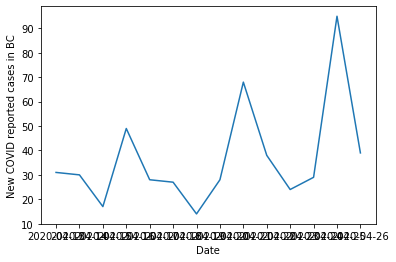

In [32]:
plt.plot(df['Date'], df['New_cases'])
plt.xlabel('Date')
plt.ylabel('New COVID reported cases in BC')

Text(0, 0.5, 'Tweets with #COVID19 from accounts registred in BC')

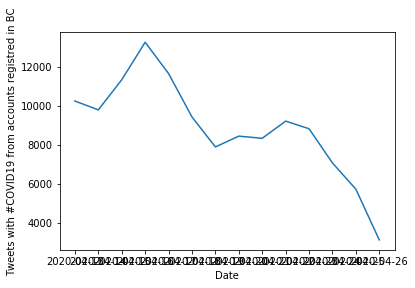

In [33]:
plt.plot(df['Date'], df['Total_tweets'])
plt.xlabel('Date')
plt.ylabel('Tweets with #COVID19 from accounts registred in BC')

In [48]:
X = training_data[:,1]
# We transform the target in order to obtain positive predictions with regression models
# We add a small number 0.01 to avoid log(0), when there are zero case
# So we predict ypred = log(y + 0.01) and recover the number of cases by exp(ypred)
y = np.log((training_data[:,2] + 0.01).astype('float64'))

In [49]:
# Cross validation to estimate the MSE (5-folds)
from sklearn.model_selection import KFold
score = []
valid_error = []
train_error = []
kf = KFold(n_splits=5, random_state=None, shuffle=True)

for train_index, test_index in kf.split(X):
    
    Xtrain, Xvalid = X[train_index], X[test_index]
    ytrain, yvalid = y[train_index], y[test_index]
    
    # Fitting model
    model = LinearRegression()
    model.fit(Xtrain.reshape(-1,1), ytrain)
    
    # R squared
    score.append(model.score(Xtrain.reshape(-1,1), ytrain))
    
    # Validation error: mean_squared_error
    yhat_train = model.predict(Xtrain.reshape(-1,1))
    yhat_valid = model.predict(Xvalid.reshape(-1,1))
    train_error.append(mean_squared_error(yhat_train, ytrain))
    valid_error.append(mean_squared_error(yhat_valid, yvalid))

print("R-squared average: ", np.mean(score))
print("Training error (MSE) average: ", np.mean(train_error))
print("Validation error (MSE) average: ", np.mean(valid_error))

R-squared average:  0.10684577108383209
Training error (MSE) average:  0.21803051048356398
Validation error (MSE) average:  0.45630119968975846


Building the second set of features

In [57]:
X = training_data[:,[1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]]
# We transform the target in order to obtain positive predictions with regression models
# We add a small number 0.01 to avoid log(0), when there are zero cases
y = np.log((training_data[:,2] + 0.01).astype('float64'))

#### Multiple linear regression: Cases ~ Total_tweets + Percentage of tweets cotaining keywords

In [58]:
# Cross validation to estimate the MSE (5-folds)
score = []
train_error = []
valid_error = []
kf = KFold(n_splits=5, random_state=None, shuffle=True)

for train_index, test_index in kf.split(X):
    Xtrain, Xvalid = X[train_index], X[test_index]
    ytrain, yvalid = y[train_index], y[test_index]
    
    # Fitting model
    model = LinearRegression()
    model.fit(Xtrain, ytrain)
    
    # R squared
    score.append(model.score(Xtrain, ytrain))
    
    # Validation error: mean_squared_error
    yhat_train = model.predict(Xtrain)
    yhat_valid = model.predict(Xvalid)
    train_error.append(mean_squared_error(yhat_train, ytrain))
    valid_error.append(mean_squared_error(yhat_valid, yvalid))

print("R-squared average: ", np.mean(score))
print("Training error (MSE) average: ", np.mean(train_error))
print("Validation error (MSE) average: ", np.mean(valid_error))

R-squared average:  1.0
Training error (MSE) average:  1.2652514958720097e-26
Validation error (MSE) average:  0.6202096362346323


#### Multiple LASSO regression: Cases ~ Total_tweets + Percentage of tweets containing keywords

In [59]:
#In this case, we are going to tune the regularization parameter
# Cross validation to estimate the MSE (5-folds)
kf = KFold(n_splits=5, random_state=None, shuffle=True)
regularization_param = np.arange(0.25,4,0.5)

for i in range(len(regularization_param)):
    print("Result for alpha = ", regularization_param[i])
    score = []
    valid_error = []
    train_error = []
    
    for train_index, test_index in kf.split(X):
        Xtrain, Xvalid = X[train_index], X[test_index]
        ytrain, yvalid = y[train_index], y[test_index]

        # Fitting model
        model = linear_model.Lasso(alpha=regularization_param[i])
        model.fit(Xtrain, ytrain)

        # R squared
        score.append(model.score(Xtrain, ytrain))

        # Validation error: mean_squared_error
        yhat_valid = model.predict(Xvalid)
        yhat_train = model.predict(Xtrain)
        train_error.append(mean_squared_error(yhat_train, ytrain))
        valid_error.append(mean_squared_error(yhat_valid, yvalid))

    print("R-squared average: ", np.mean(score))
    print("Training error (MSE) average: ", np.mean(train_error))
    print("Validation error (MSE) average: ", np.mean(valid_error))

Result for alpha =  0.25
R-squared average:  0.3058068751550117
Training error (MSE) average:  0.1669047821837915
Validation error (MSE) average:  0.4555229541008335
Result for alpha =  0.75
R-squared average:  0.15627456633256673
Training error (MSE) average:  0.19959200887947115
Validation error (MSE) average:  0.5702133889449102
Result for alpha =  1.25
R-squared average:  0.11988294057368602
Training error (MSE) average:  0.2120695281344343
Validation error (MSE) average:  0.4730690080972678
Result for alpha =  1.75
R-squared average:  0.13390324681372878
Training error (MSE) average:  0.21034665299445748
Validation error (MSE) average:  0.3894226863260909
Result for alpha =  2.25
R-squared average:  0.14981732033520728
Training error (MSE) average:  0.20155048430745995
Validation error (MSE) average:  0.5744641846501781
Result for alpha =  2.75
R-squared average:  0.10078183266907806
Training error (MSE) average:  0.21883467975008122
Validation error (MSE) average:  0.438377228442

#### Multiple RIDGE regression: Cases ~ Total_tweets + Percentage of tweets containing keywords

In [60]:
#In this case, we are going to tune the regularization parameter
# Cross validation to estimate the MSE (5-folds)
kf = KFold(n_splits=5, random_state=None, shuffle=True)
regularization_param = np.arange(0.25,4,0.5)

for i in range(len(regularization_param)):
    print("Result for alpha = ", regularization_param[i])
    score = []
    valid_error = []
    train_error = []
    
    for train_index, test_index in kf.split(X):
        Xtrain, Xvalid = X[train_index], X[test_index]
        ytrain, yvalid = y[train_index], y[test_index]

        # Fitting model
        model = linear_model.Ridge(alpha=regularization_param[i])
        model.fit(Xtrain, ytrain)

        # R squared
        score.append(model.score(Xtrain, ytrain))

        # Validation error: mean_squared_error
        yhat_valid = model.predict(Xvalid)
        yhat_train = model.predict(Xtrain)
        train_error.append(mean_squared_error(yhat_train, ytrain))
        valid_error.append(mean_squared_error(yhat_valid, yvalid))

    print("R-squared average: ", np.mean(score))
    print("Training error (MSE) average: ", np.mean(train_error))
    print("Validation error (MSE) average: ", np.mean(valid_error))

Result for alpha =  0.25
R-squared average:  0.9311643244825255
Training error (MSE) average:  0.016271065534548008
Validation error (MSE) average:  0.446765830629694
Result for alpha =  0.75
R-squared average:  0.8171799452677371
Training error (MSE) average:  0.04340905215974585
Validation error (MSE) average:  0.31862349553870334
Result for alpha =  1.25
R-squared average:  0.7584341086053932
Training error (MSE) average:  0.05840096625698364
Validation error (MSE) average:  0.37787826245319606
Result for alpha =  1.75
R-squared average:  0.7413671056535903
Training error (MSE) average:  0.06279303084089005
Validation error (MSE) average:  0.4870518389769061
Result for alpha =  2.25
R-squared average:  0.6903903070507229
Training error (MSE) average:  0.06791539315531273
Validation error (MSE) average:  0.38055777101510946
Result for alpha =  2.75
R-squared average:  0.7047733534899965
Training error (MSE) average:  0.06785420120447236
Validation error (MSE) average:  0.523691718499

#### Random forest: Cases ~ Total_tweets + Percentage of tweets containing keywords

In [62]:
#In this case, we are going to tune the number of trees
# Cross validation to estimate the MSE (5-folds)
kf = KFold(n_splits=5, random_state=None, shuffle=True)
ntrees = [10,50,100,300,500,800,1000]

for i in range(len(ntrees)):
    print("Result for ntrees = ", ntrees[i])
    valid_error = []
    train_error = []
    
    for train_index, test_index in kf.split(X):
        Xtrain, Xvalid = X[train_index], X[test_index]
        ytrain, yvalid = y[train_index], y[test_index]

        # Fitting model
        model = RandomForestRegressor(n_estimators = ntrees[i])
        model.fit(Xtrain, ytrain)

        # Validation error: mean_squared_error
        yhat_valid = model.predict(Xvalid)
        yhat_train = model.predict(Xtrain)
        train_error.append(mean_squared_error(yhat_train, ytrain))
        valid_error.append(mean_squared_error(yhat_valid, yvalid))

    print("R-squared average: ", np.mean(score))
    print("Training error (MSE) average: ", np.mean(train_error))
    print("Validation error (MSE) average: ", np.mean(valid_error))

Result for ntrees =  10
R-squared average:  0.07849336696740525
Training error (MSE) average:  0.03953562833079298
Validation error (MSE) average:  0.40945539752039417
Result for ntrees =  50
R-squared average:  0.07849336696740525
Training error (MSE) average:  0.03836796482887594
Validation error (MSE) average:  0.21682718859992392
Result for ntrees =  100
R-squared average:  0.07849336696740525
Training error (MSE) average:  0.03455196939234301
Validation error (MSE) average:  0.2735951571495827
Result for ntrees =  300
R-squared average:  0.07849336696740525
Training error (MSE) average:  0.030423888493166913
Validation error (MSE) average:  0.28022586130248756
Result for ntrees =  500
R-squared average:  0.07849336696740525
Training error (MSE) average:  0.03313370539457872
Validation error (MSE) average:  0.2583822562825145
Result for ntrees =  800
R-squared average:  0.07849336696740525
Training error (MSE) average:  0.033345939371865495
Validation error (MSE) average:  0.263184